In [20]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import os
import matplotlib.pyplot as plt
from misc_funcs import get_samples, indexes
from dataset_specifications.dataset import LabelledData
from networks import NoiseInjection, FeedForward, DoubleInputNetwork
from cgan_versions import PearsonCGAN, KLCGAN, RKLCGAN, WCGAN
from cgan import CGAN
import seaborn as sns
import pandas as pd
import evaluation as eval
import scipy.stats as ss
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler


plt.rcParams.update({'font.size': 13})
plt.rc("axes", labelsize=18)
plt.rc("axes", titlesize=21)
plt.rc("legend", fontsize=18)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
# wmix6
def sample_ys(xs):
    comp_offsets= xs[:,:2]
    weights = xs[:,2:4]
    comp_shape_mods = xs[:,4:]

    # Component probabilities (normalized weights)
    comp_probs = weights / np.sum(weights, axis=1, keepdims=True)
    comp_i = np.apply_along_axis(
        (lambda probs: np.random.choice(2, size=1, p=probs)),
            1, comp_probs) # Axis should be 1, see numpy docs
    # Shape (n, 1)

    # Get values for chosen component (component with sampled index)
    offsets = np.take_along_axis(comp_offsets, comp_i, 1)
    shape_mods = np.take_along_axis(comp_shape_mods, comp_i, 1)
    shape_params = 1. + shape_mods

    w_samples = np.random.weibull(shape_params)
    # Shape (n, 1)
    ys = w_samples + 5.*offsets

    return ys

def sample(xs = np.random.uniform(low=0.0, high=1.0, size=(5000, 6))):
    n = len(xs)
    # xs is from Uniform(0,1)^(dim(x))
    assert n == len(xs), 'noise length should be same as xs length'    
    ys = sample_ys(xs)
    return np.concatenate((xs, ys), axis=1)

def get_pdf(x):
    # Perform pdf computation in pytorch
    if type(x) == torch.Tensor:
        x = x.to("cpu")
    else:
        x = torch.tensor(x)

    comp_offsets = x[:2]
    weights = x[2:4]
    comp_shape_mods = x[4:]

    comp_probs = weights / torch.sum(weights)

    shapes = 1.0 + comp_shape_mods
    scales = torch.ones_like(shapes)

    w_dists = torch.distributions.weibull.Weibull(scales, shapes, validate_args=False)

    def pdf(y):
        no_offsets = y - 5.0*comp_offsets
        positive = (no_offsets >= 0.0)
        # Only use probability density for positive samples (within support)
        # Pytorch gives positive density even outside support for some reason

        log_probs = w_dists.log_prob(no_offsets)

        filtered_probs = torch.exp(log_probs[positive])
        pd = torch.sum(filtered_probs * comp_probs[positive])
        return pd

    return pdf
def get_support():
    return (0.1,10.)

Next few blocks are for regenerating dataset; if not needed skip

In [26]:
num_samples_real = 300

In [27]:
# Sampling from wmix6 
n = 6600 #number of samples
x_samples = np.random.uniform(low=0.0, high=1.0, size=(n, 6))
combined = sample(x_samples)

In [28]:
combined_train, combined_validation = model_selection.train_test_split(combined, test_size=0.2, random_state=43)

scaler = StandardScaler()
train_set_scaled = scaler.fit_transform(combined_train)
# Scale test data based on training data
val_set_scaled = scaler.transform(combined_validation)
tmp = np.random.choice(len(combined_validation),50, replace=False)
x_samples_test_repeated = np.repeat(combined_validation[tmp,:-1], repeats=num_samples_real, axis = 0)
combined_test = sample(x_samples_test_repeated)
test_set_scaled = scaler.transform(combined_test)

In [29]:
# Make sure that wmix set from above corresponds to data imported below

#export data
DATASET_PATH = './datasets'
DATASET_NAME = 'wmix6'

# preprocessing folder
raw_dataset_path = os.path.join(DATASET_PATH,DATASET_NAME,'raw_data')

if not os.path.exists(raw_dataset_path):
    os.makedirs(raw_dataset_path)

# raw data
np.savetxt("./{}/{}/raw_data/train.csv".format(DATASET_PATH,DATASET_NAME), combined_train,delimiter=",")
np.savetxt("./{}/{}/raw_data/val.csv".format(DATASET_PATH,DATASET_NAME), combined_validation,delimiter=",")
np.savetxt("./{}/{}/raw_data/test.csv".format(DATASET_PATH,DATASET_NAME), combined_test,delimiter=",")
#scaled data
np.savetxt("./{}/{}/train.csv".format(DATASET_PATH,DATASET_NAME), train_set_scaled,delimiter=",")
np.savetxt("./{}/{}/val.csv".format(DATASET_PATH,DATASET_NAME), val_set_scaled,delimiter=",")
np.savetxt("./{}/{}/test.csv".format(DATASET_PATH,DATASET_NAME), test_set_scaled,delimiter=",")

In [30]:
tmp = np.random.choice(len(combined_train),50, replace=False)
x_samples_train_repeated = np.repeat(combined_train[tmp,:-1], repeats=num_samples_real, axis = 0)
combined_train_repeated = sample(x_samples_train_repeated)
train_set_repeated_scaled = scaler.transform(combined_train_repeated)
np.savetxt("./{}/train_repeated.csv".format(raw_dataset_path), combined_train_repeated,delimiter=",")
np.savetxt("./{}/{}/train_repeated.csv".format(DATASET_PATH,DATASET_NAME), train_set_repeated_scaled,delimiter=",")

Importing and running the model starts from here

In [31]:
#import data
DATASET_PATH = './datasets'
DATASET_NAME = 'wmix6'
dataset_dir = os.path.join(DATASET_PATH,DATASET_NAME)
assert os.path.exists(dataset_dir),("dataset folder {} does not exist".format(dataset_dir))

splits = {}
#CHANGE DIMENSIONS OF DATA ACCORDINGLY
X_DIM = 6
Y_DIM = 1
scatter_plot = 0

for split in ("train","val","test",'train_repeated'):
    data_path = os.path.join(dataset_dir,"{}.csv".format(split))
    assert os.path.exists(data_path),"data file {} does not exist".format(data_path)
    
    data = np.genfromtxt(data_path,delimiter=",")
    if scatter_plot:
        plt.figure
        plt.scatter(data[:,:1],data[:,1:], c='k', s=3)
        plt.xlabel("x")
        plt.ylabel('y')
        plt.title(split)
        save_path = os.path.join("./plots", DATASET_NAME)
        plt.savefig('{}/{}.png'.format(save_path,split))
        plt.show()
        plt.close()
    torch_data = torch.tensor(data, device="cpu").float()
    splits[split] = LabelledData(x=torch_data[:,:X_DIM],y=torch_data[:,X_DIM:])

train_data = splits["train"]
val_data = splits['val']
test_data = splits['test']
train_data_repeated = splits['train_repeated']

In [45]:
# path for saving parameters of model
PARAM_PATH = './param_best'
FILE_NAME = 'wmix6_WCGAN'

# For saving plots
PLOT_PATH = './plots'
PLT_DATASET_NAME = 'wmix6'


constants = {
    "dataset_path": DATASET_PATH,
    "dataset_name": DATASET_NAME,
    "plot_path": PLOT_PATH,
    "plt_dataset_name": PLT_DATASET_NAME,
    "param_path": PARAM_PATH,
    "file_name": FILE_NAME,
    "x_dim": X_DIM,
    "y_dim": Y_DIM
}

In [46]:
def val_func(model, epoch):
    return eval.evaluate_model(model, data_val = val_data, data_train = train_data, 
                            data_test = test_data,data_train_repeated=train_data_repeated, epoch = epoch)

Epoch 19, true	ll: -1.4383	mae: 0.83057	Wasserstein-1 dist: 0.80099	Wasserstein-2 dist: 0.94955
Epoch 39, true	ll: -1.3386	mae: 0.75999	Wasserstein-1 dist: 0.6486	Wasserstein-2 dist: 0.76773
Epoch 59, true	ll: -1.2205	mae: 0.66128	Wasserstein-1 dist: 0.3449	Wasserstein-2 dist: 0.42222
Epoch 79, true	ll: -1.1617	mae: 0.63487	Wasserstein-1 dist: 0.11126	Wasserstein-2 dist: 0.14792
Epoch 99, true	ll: -1.226	mae: 0.66645	Wasserstein-1 dist: 0.2042	Wasserstein-2 dist: 0.26837
Epoch 119, true	ll: -1.2911	mae: 0.69659	Wasserstein-1 dist: 0.27486	Wasserstein-2 dist: 0.32397
Epoch 139, true	ll: -1.2112	mae: 0.66046	Wasserstein-1 dist: 0.15451	Wasserstein-2 dist: 0.18448
Epoch 159, true	ll: -1.1511	mae: 0.63218	Wasserstein-1 dist: 0.053104	Wasserstein-2 dist: 0.074529
Epoch 179, true	ll: -1.1442	mae: 0.62638	Wasserstein-1 dist: 0.068656	Wasserstein-2 dist: 0.099621
Epoch 199, true	ll: -1.1433	mae: 0.63034	Wasserstein-1 dist: 0.055861	Wasserstein-2 dist: 0.079919
Epoch 219, true	ll: -1.149	mae: 0

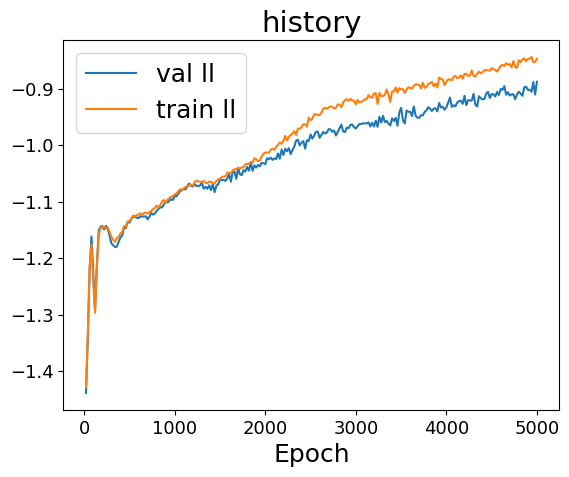

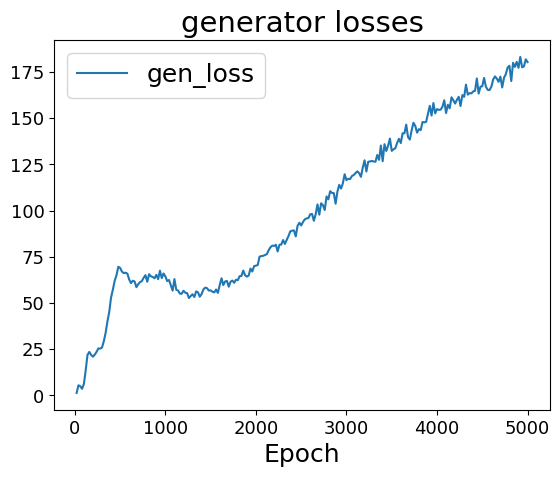

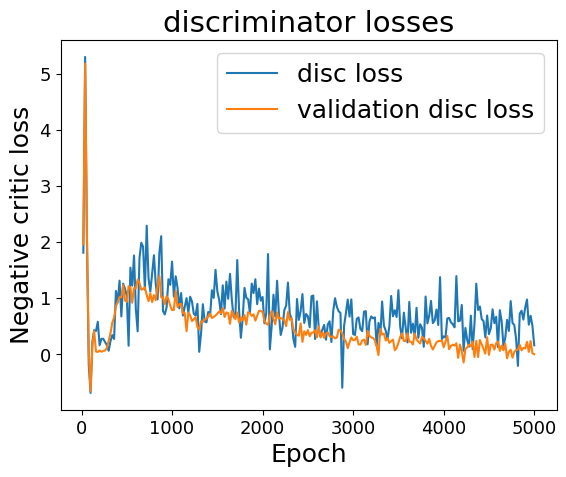

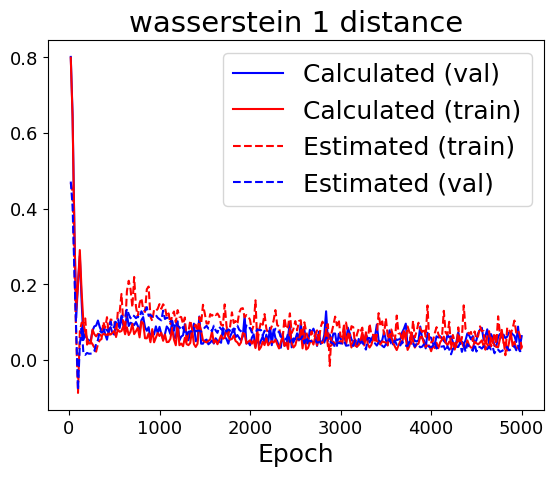

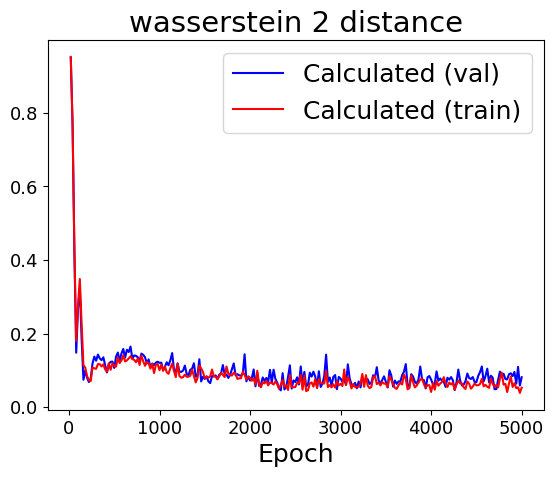

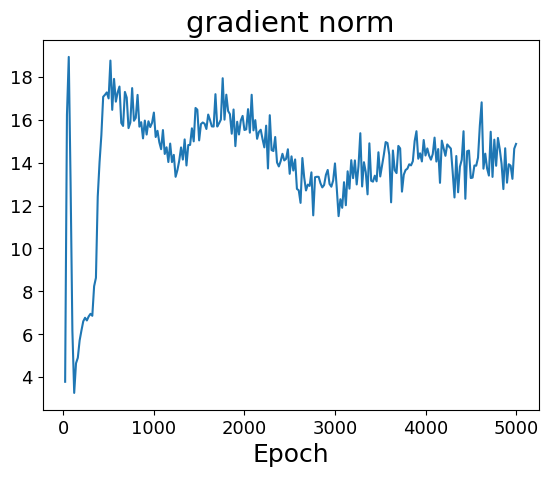

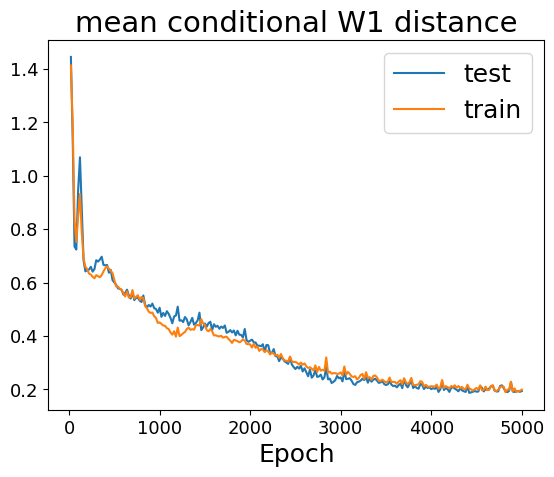

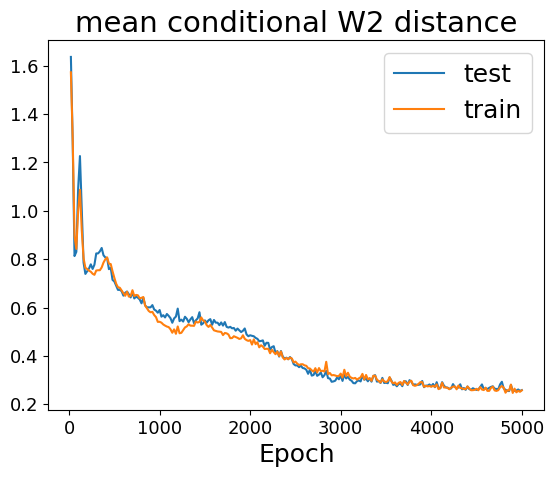

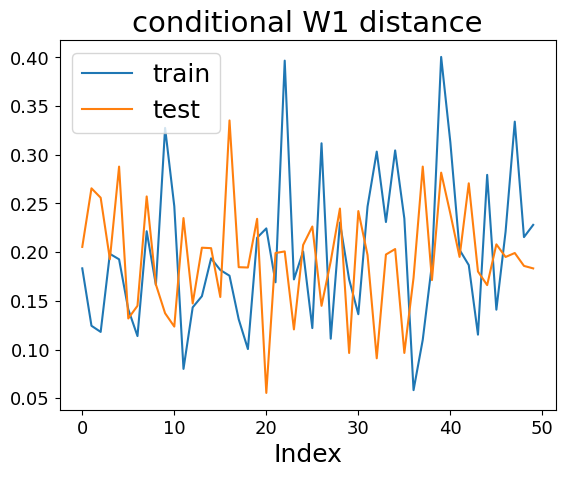

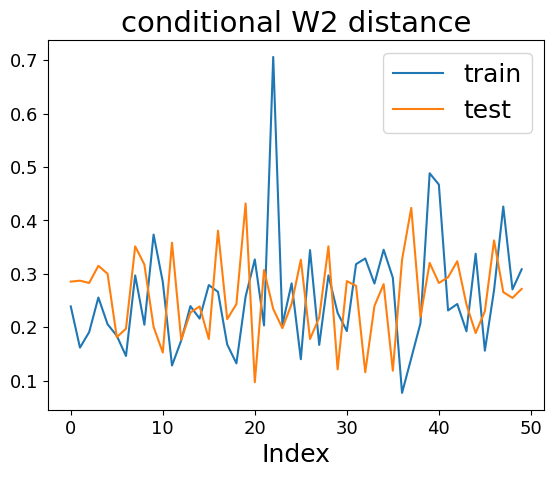

In [55]:
# config for WCGAN
config = {
    "noise_dim": 30,
    "epochs": 5000,
    "batch_size": 200,
    "gen_lr": 1e-4,
    "disc_lr": 2e-4,
    "val_interval": 20,
    "eval_batch_size": 1000,
    "eval_samples": 200,
    "kernel_scales": 50,
    "kernel_scale_min": 0.001,
    "kernel_scale_max": 0.7,
    "pdf_index":"100",
    "scatter": 0,
    "kde_batch_size": 15,
    "n_critic": 5,
    "lambda_gp": 2e-2,
    'one-sided': True
}


nn_spec = {'gen_spec' : {
    "other_dim": config["noise_dim"],#noise dimensions
    "cond_dim": X_DIM,#conditioning data
    "nodes_per_layer": [64,64,64,64],
    "output_dim": Y_DIM,#fake data dimensions
    "activation": nn.ReLU(),
    "type": FeedForward,
    "dropout":None,
    "activation_final": 0,
    "batch_norm": None,
    "spectral_normalisation": None
},
'disc_spec': {
    "other_dim": Y_DIM,#actual data dimensions
    "cond_dim": X_DIM,
    "nodes_per_layer": [64,64,64,64],
    "output_dim": 1,#output logit
    "activation": nn.ReLU(),
    "type": FeedForward,
    "dropout":None,
    "activation_final": 0,
    "batch_norm": None,
    "spectral_normalisation": None
}
}
cgan_model = WCGAN(config, nn_spec, constants)
cgan_model.train(train_data, val_data, test_data, val_func)

Epoch 19, true	ll: -1.4468	mae: 0.85376	Wasserstein-1 dist: 0.14039	Wasserstein-2 dist: 0.18401
Epoch 39, true	ll: -1.4488	mae: 0.84903	Wasserstein-1 dist: 0.18543	Wasserstein-2 dist: 0.23124
Epoch 59, true	ll: -1.2748	mae: 0.69706	Wasserstein-1 dist: 0.13362	Wasserstein-2 dist: 0.15248
Epoch 79, true	ll: -1.2283	mae: 0.66034	Wasserstein-1 dist: 0.06875	Wasserstein-2 dist: 0.10016
Epoch 99, true	ll: -1.2604	mae: 0.68381	Wasserstein-1 dist: 0.060628	Wasserstein-2 dist: 0.08058
Epoch 119, true	ll: -1.2269	mae: 0.65038	Wasserstein-1 dist: 0.067712	Wasserstein-2 dist: 0.092304
Epoch 139, true	ll: -1.213	mae: 0.64124	Wasserstein-1 dist: 0.059801	Wasserstein-2 dist: 0.071111
Epoch 159, true	ll: -1.1627	mae: 0.63191	Wasserstein-1 dist: 0.052423	Wasserstein-2 dist: 0.067333
Epoch 179, true	ll: -1.1402	mae: 0.62149	Wasserstein-1 dist: 0.070179	Wasserstein-2 dist: 0.080286
Epoch 199, true	ll: -1.1332	mae: 0.60926	Wasserstein-1 dist: 0.040146	Wasserstein-2 dist: 0.070397
Epoch 219, true	ll: -1.13

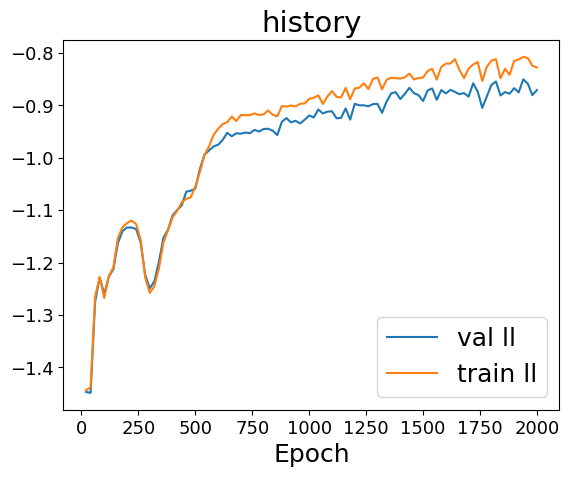

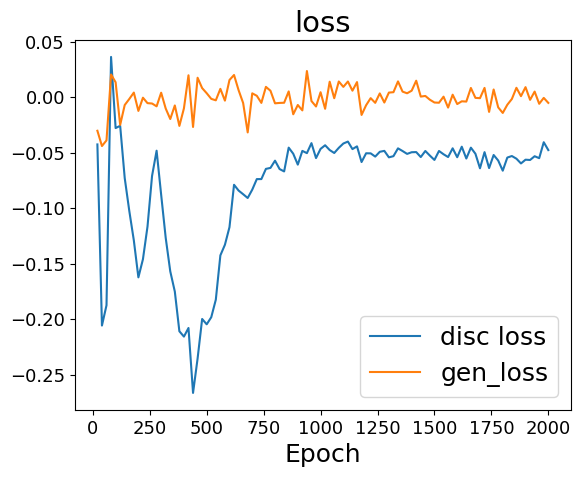

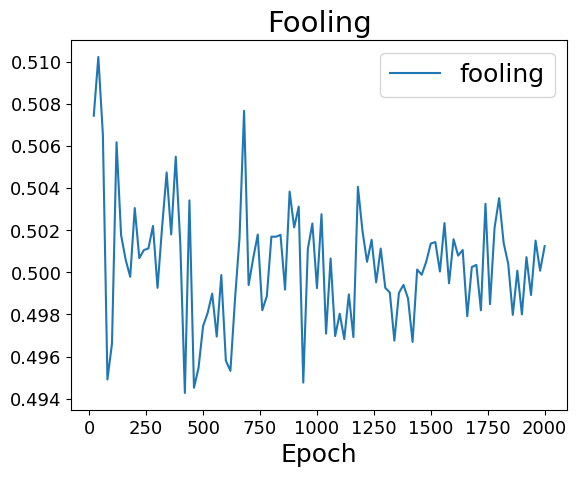

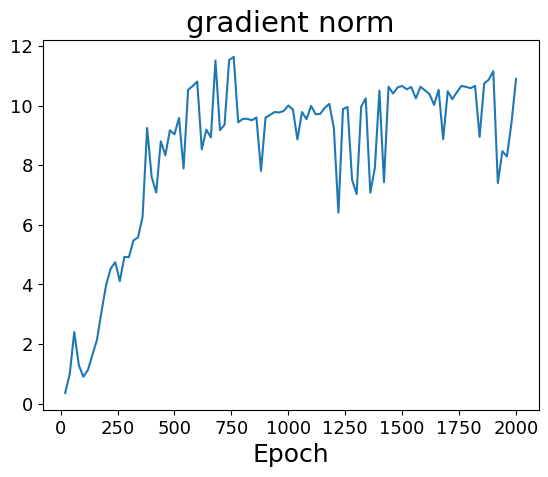

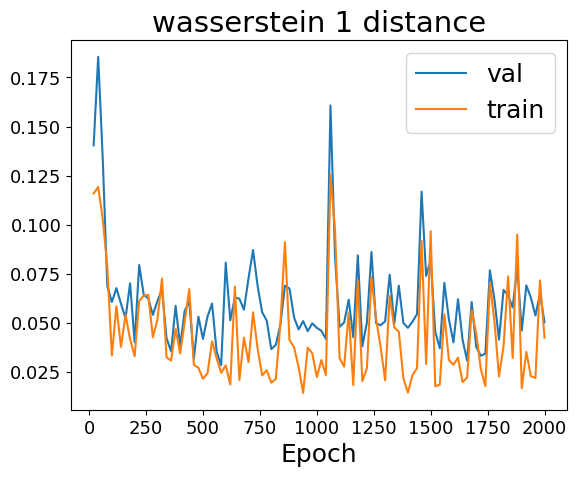

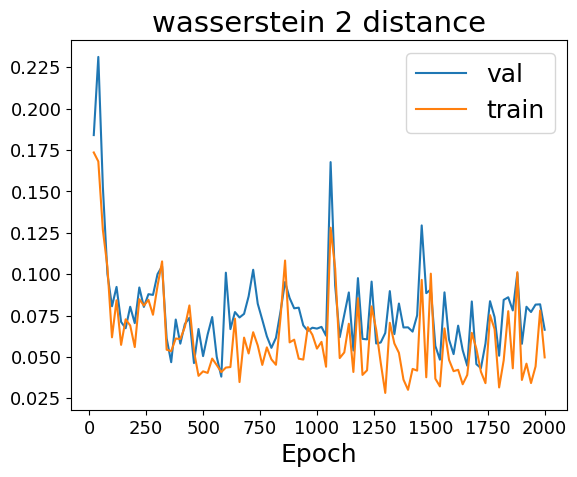

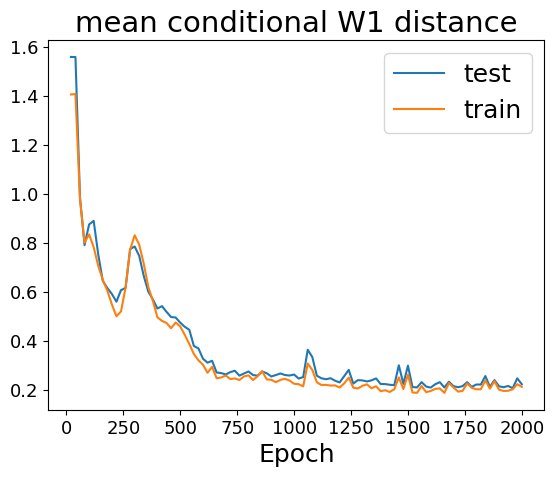

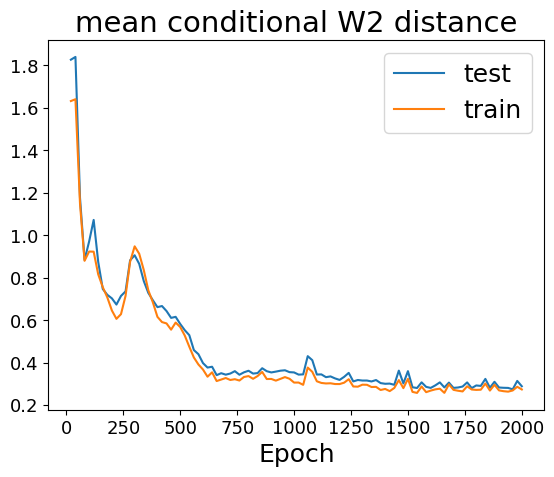

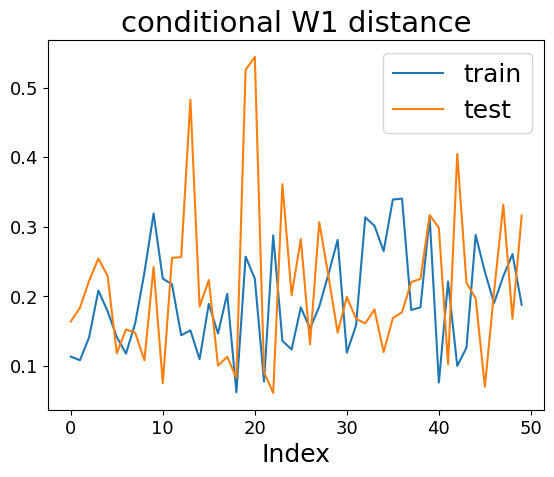

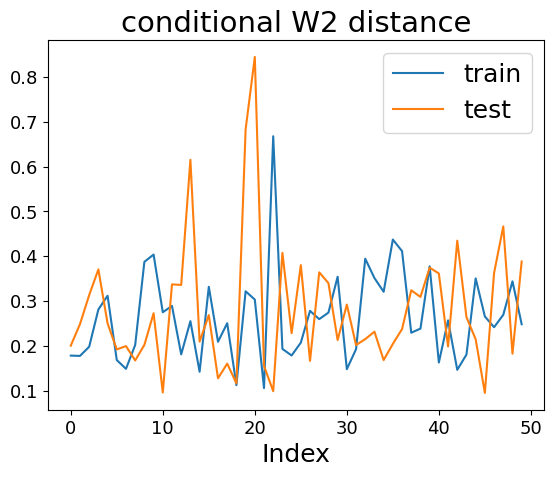

In [41]:
#create nn spec for discriminator and generator
config = {
    "noise_dim": 30,
    "epochs": 2000,
    "batch_size": 200,
    "gen_lr": 1e-4,
    "disc_lr": 1e-4,
    "val_interval": 20,
    "eval_batch_size": 1000,
    "eval_samples": 200,
    "kernel_scales": 50,
    "kernel_scale_min": 0.001,
    "kernel_scale_max": 0.5,
    "pdf_index":'100',
    "scatter": 0,
    "kde_batch_size": 10,
}

# # medium
nn_spec = {'gen_spec' : {
    "other_dim": config["noise_dim"],#noise dimensions
    "cond_dim": X_DIM,#conditioning data
    "nodes_per_layer": [16, 16, 16, 16, 16],
    "output_dim": Y_DIM,#fake data dimensions
    "activation": nn.ReLU(),
    "type": NoiseInjection,
    "dropout":None,
    "activation_final": 0,
    "spectral_normalisation": None
},
'disc_spec': {
    "other_dim": Y_DIM,#actual data dimensions
    "cond_dim": X_DIM,
    "nodes_per_layer": [16, 16, 16],
    "cond_layers": [16],
    "other_layers":[16],
    "output_dim": 1,#output logit
    "activation": nn.ReLU(),
    "type": DoubleInputNetwork,
    "dropout":None,
    "activation_final": 0,
    "spectral_normalisation": None
}
}
cgan_model = PearsonCGAN(config, nn_spec, constants)
cgan_model.train(train_data, val_data, test_data, val_func)

In [48]:
# extract x-values of real (empirical) pdf
x_values_scale, x_values_index = np.unique(test_data.x, axis = 0, return_index=True)
x_values = np.unique(test_data.x, axis = 0)
num_samples_gen = 3000
sort =np.argsort(x_values_index)
x_values_scale = x_values_scale[sort]
x_values_index = x_values_index[sort]
x_values = x_values[sort]

In [49]:
# preprocessing folder
samplepdf_imgs_path = os.path.join(PLOT_PATH,PLT_DATASET_NAME,FILE_NAME,'Sample_PDF')

if not os.path.exists(samplepdf_imgs_path):
    os.makedirs(samplepdf_imgs_path)
else:
    for f in os.listdir(samplepdf_imgs_path):
        os.remove(os.path.join(samplepdf_imgs_path,f))


In [54]:
# plot generated pdf against real (empirical) pdf
assert os.path.exists(samplepdf_imgs_path),("dataset folder {} does not exist".format(samplepdf_imgs_path))
gen_samples = np.zeros((num_samples_gen,len(x_values_scale)))
real_samples = np.zeros((num_samples_real,len(x_values_scale)))

print('Plotting samples for all x-locations...')
for i, (idx,values_scaled) in enumerate(zip(x_values_index, x_values_scale)):
    gen_samples[:,i] = get_samples(cgan_model, values_scaled, num_samples_gen).squeeze(1)
    plt.figure()
    sns.kdeplot(gen_samples[:,i], color ='b',label='Gen', bw_adjust=0.75)
    tmp = indexes(test_data.x[idx], test_data.x)
    real_samples[:,i] = test_data.y[tmp].squeeze()
    sns.kdeplot(real_samples[:,i], color='k', linestyle='--', label='Empirical')
    plt.title('x={}'.format(x_values[i]), fontsize=10)
    plt.tight_layout()
    plt.legend()
    plt.savefig('{}/idx_{}.png'.format(samplepdf_imgs_path, i))
    plt.close()
print('Plotting samples for all x-locations finished')


Plotting samples for all x-locations...
Plotting samples for all x-locations finished


(array([-2500.,     0.,  2500.,  5000.,  7500., 10000., 12500., 15000.,
        17500., 20000., 22500.]),
 [Text(-2500.0, 0, '−2500'),
  Text(0.0, 0, '0'),
  Text(2500.0, 0, '2500'),
  Text(5000.0, 0, '5000'),
  Text(7500.0, 0, '7500'),
  Text(10000.0, 0, '10000'),
  Text(12500.0, 0, '12500'),
  Text(15000.0, 0, '15000'),
  Text(17500.0, 0, '17500'),
  Text(20000.0, 0, '20000'),
  Text(22500.0, 0, '22500')])

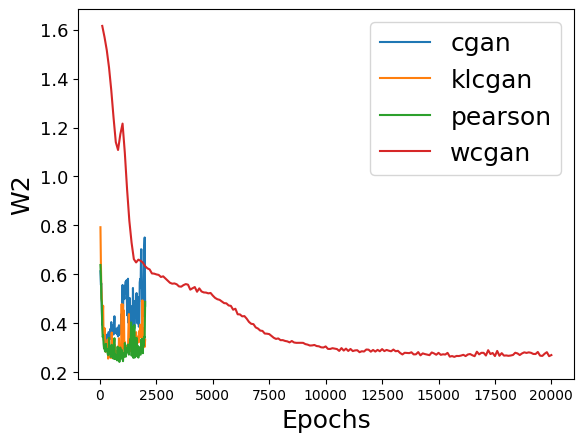

In [21]:
path = os.path.join('postprocess','wmix6','regular','wasserstein_dist.csv')
tmp = pd.read_csv(path, delimiter=',')
plt.figure()
for model in ('cgan', "klcgan", "pearson"):
    plt.plot(tmp['epoch'],tmp[model], label=model)
plt.plot(tmp['epoch.1'],tmp['wcgan'], label = 'wcgan')
plt.legend()
plt.ylabel("W2")
plt.xlabel('Epochs')
# plt.ticklabel_format(axis='x',scilimits=(0,1), style='sci')
plt.xticks(fontsize=10)
# plt.xticks(ticks = plt.xticks()[0],labels=plt.xticks()[0].astype(int))
# plt.figure()
# plt.plot(tmp[:,0],tmp)